In [ ]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<AxesSubplot:xlabel='pattern', ylabel='count'>

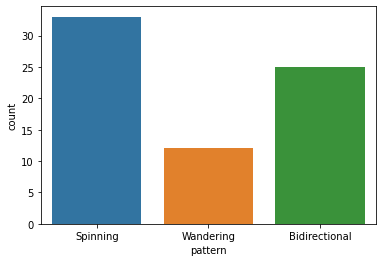

In [ ]:
dfData = pd.read_pickle("/content/drive/My Drive/Macrophages_MigratoryPatterns_DL/clusters_withFeatures.txt")
dfData = dfData[dfData.pattern != 'Mix']

#tuples (x,y)
tup1 = []
for i in range(len(dfData)):
    tupxy = [];
    ##Normalize values
    x_vals = dfData.traj[i][0]
    x_vals -= np.mean(x_vals)
    x_vals /= np.std(x_vals)

    y_vals = dfData.traj[i][1]
    y_vals -= np.mean(y_vals)
    y_vals /= np.std(y_vals)

    pers_vals = dfData.traj[i][2]
    pers_vals -= np.mean(pers_vals)
    pers_vals /= np.std(pers_vals)

    dist_vals = dfData.traj[i][3]
    dist_vals -= np.mean(dist_vals)
    dist_vals /= np.std(dist_vals)

    for k in range(len(dfData.traj[0][0])-1):
        tupxy.append((x_vals[k],y_vals[k], pers_vals[k], dist_vals[k]))

        #tupxy.append((dfData.traj[i][0][k],dfData.traj[i][1][k],dfData.traj[i][2][k],dfData.traj[i][3][k]))
    tup1.append(tupxy)


dfData['tup_traj'] = tup1


dfnn = dfData.drop(labels = ['traj','patternNo'],axis =1) #'parentImg'


sns.countplot(x='pattern', data =dfnn)

In [ ]:
trajs_list = dfnn['tup_traj'].values.tolist() # convert the dataframe column to list
trajs = np.array(trajs_list)
traj_labels = dfnn['pattern']


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

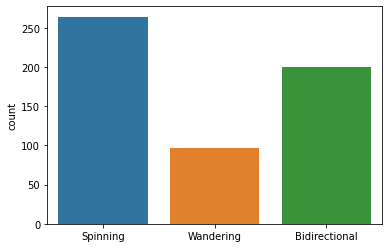

In [ ]:
#data augmentation
ntrajs = []
ntraj_labels = []


for cl in trajs :
    temp_aug = []
    for a in range(8):
        temp_aug.append([])
    for co in cl :
        temp_aug[0].append((co[0],co[1], co[2], co[3]))  #(x,y)
        temp_aug[1].append((co[1],co[0], co[2], co[3]))  #(y,x)
        temp_aug[2].append((-co[0],co[1], co[2], co[3])) #(-x,y)
        temp_aug[3].append((-co[0],-co[1], co[2], co[3])) #(-x,-y)
        temp_aug[4].append((co[0],-co[1], co[2], co[3])) #(x,-y)

        temp_aug[5].append((-co[1],co[0], co[2], co[3])) #(-y,x)
        temp_aug[6].append((-co[1],-co[0], co[2], co[3])) #(-y,-x)
        temp_aug[7].append((co[1],-co[0], co[2], co[3])) #(y,-x)
    for ma in temp_aug :
        ntrajs.append(ma)

for a in range(len(trajs)):
    for b in range(8):
        ntraj_labels.append(traj_labels[a])

ntrajs = np.array(ntrajs)
ntraj_labels = np.array(ntraj_labels)

sns.countplot(ntraj_labels, data =dfnn)

In [ ]:

#Deep learnining model
from sklearn.utils import shuffle

#shuffle the training data to improve the val accuracy scoere -- Used instead of #np.random.shuffle(rank_3_tensor_train)
all_data, all_labels = shuffle(ntrajs, ntraj_labels, random_state=42)


#Split train:test = 80:20
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(all_data, all_labels, test_size=0.2, random_state=42)

#Change the string labels to float
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.fit_transform(y_test)

#One hot encode y values for neural network.
from keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train_encoded)
y_test_one_hot = to_categorical(y_test_encoded)

##Fit data to model and split train to validation
x_val = x_train[:100]
partial_x_train = x_train[100:]

y_val = y_train_one_hot[:100]
partial_y_train = y_train_one_hot[100:]



In [ ]:
#Model
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout


def build_model():
    feature_extractor = Sequential()
    feature_extractor.add(Dense(10, activation='relu',kernel_initializer='he_uniform',  input_shape=(36,4)))
    feature_extractor.add(Dense(20, kernel_initializer='he_uniform', activation='relu'))
    feature_extractor.add(Dense(32, kernel_initializer='he_uniform', activation='relu'))
    feature_extractor.add(Dense(64, kernel_initializer='he_uniform', activation='relu'))
    feature_extractor.add(Dense(64, kernel_initializer='he_uniform', activation='relu'))
    feature_extractor.add(Dense(32, kernel_initializer='he_uniform', activation='relu'))
    feature_extractor.add(Dense(20, kernel_initializer='he_uniform', activation='relu'))
    feature_extractor.add(Dense(10, kernel_initializer='he_uniform', activation='relu'))
    feature_extractor.add(Flatten())
    x = feature_extractor.output

    prediction_layer = Dense(3, activation = 'softmax')(x)

    cnn_model = Model(inputs=feature_extractor.input, outputs=prediction_layer)
    cnn_model.compile(optimizer='rmsprop',loss = 'categorical_crossentropy', metrics = ['accuracy'])
    print(cnn_model.summary())
    return cnn_model


In [ ]:
model =  build_model()
history = model.fit(partial_x_train, partial_y_train, epochs=100, validation_data = (x_val, y_val))


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_input (InputLayer)    [(None, 36, 4)]           0         
                                                                 
 dense (Dense)               (None, 36, 10)            50        
                                                                 
 dense_1 (Dense)             (None, 36, 20)            220       
                                                                 
 dense_2 (Dense)             (None, 36, 32)            672       
                                                                 
 dense_3 (Dense)             (None, 36, 64)            2112      
                                                                 
 dense_4 (Dense)             (None, 36, 64)            4160      
                                                                 
 dense_5 (Dense)             (None, 36, 32)            2080  

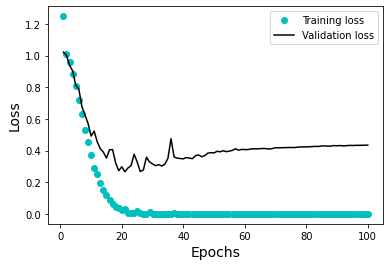

In [ ]:


#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'co', label='Training loss')
plt.plot(epochs, val_loss, 'k-', label='Validation loss')
#plt.title('Training and Validation loss')
plt.xlabel('Epochs',fontsize="14")
plt.ylabel('Loss',fontsize="14")
#plt.xlim(0,20)
plt.legend()
plt.show()

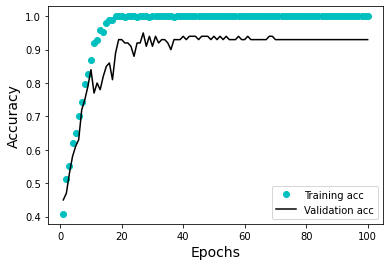

In [ ]:
##Plotting the training and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'co', label='Training acc')
plt.plot(epochs, val_acc, 'k', label='Validation acc')
#plt.title('Training and Validation accuracy')
plt.xlabel('Epochs',fontsize="14")
plt.ylabel('Accuracy',fontsize="14")
plt.legend()
plt.show()


In [ ]:
#de-encode to normal labels
#model =  build_model()
prediction_NN = model.predict(x_test)
prediction_NN = np.argmax(prediction_NN, axis=-1)
prediction_NN = le.inverse_transform(prediction_NN)

#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, prediction_NN)
print(cm)
#sns.heatmap(cm, annot=True, cmap="YlGnBu", xticklabels=['Bidirectional','Spinning','Wandering'], yticklabels=['Bidirectional','Spinning','Wandering'])



4/4 [==============================] - 0s 6ms/step
[[29  3  0]
 [ 7 52  1]
 [ 0  1 19]]


<AxesSubplot:>

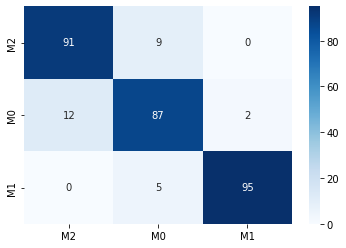

In [ ]:
sns.heatmap(np.round(cm*100/np.sum(cm, axis=1, keepdims=True)), annot=True, cmap="Blues", xticklabels=['M2','M0','M1'], yticklabels=['M2','M0','M1'])


In [ ]:

from sklearn.metrics import accuracy_score
accuracy_score(y_test, prediction_NN, normalize=False)

print(prediction_NN)

['Spinning' 'Spinning' 'Wandering' 'Spinning' 'Spinning' 'Spinning'
 'Wandering' 'Bidirectional' 'Spinning' 'Spinning' 'Spinning' 'Spinning'
 'Bidirectional' 'Spinning' 'Bidirectional' 'Bidirectional' 'Spinning'
 'Bidirectional' 'Spinning' 'Spinning' 'Spinning' 'Spinning' 'Spinning'
 'Spinning' 'Spinning' 'Bidirectional' 'Wandering' 'Bidirectional'
 'Spinning' 'Bidirectional' 'Spinning' 'Spinning' 'Wandering' 'Spinning'
 'Spinning' 'Bidirectional' 'Bidirectional' 'Bidirectional' 'Spinning'
 'Spinning' 'Wandering' 'Bidirectional' 'Bidirectional' 'Spinning'
 'Spinning' 'Bidirectional' 'Bidirectional' 'Wandering' 'Bidirectional'
 'Spinning' 'Spinning' 'Spinning' 'Spinning' 'Wandering' 'Spinning'
 'Wandering' 'Bidirectional' 'Bidirectional' 'Wandering' 'Bidirectional'
 'Spinning' 'Bidirectional' 'Wandering' 'Spinning' 'Spinning' 'Wandering'
 'Spinning' 'Spinning' 'Spinning' 'Spinning' 'Bidirectional' 'Wandering'
 'Spinning' 'Spinning' 'Spinning' 'Bidirectional' 'Bidirectional'
 'Bidirectio

In [ ]:

def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

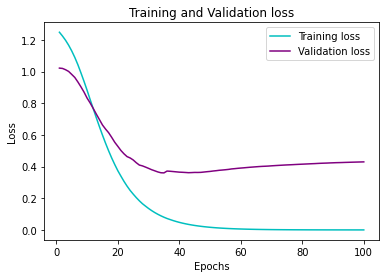

In [ ]:
smooth_loss_hist = smooth_curve(loss)
smooth_val_loss_hist = smooth_curve(val_loss)
plt.plot(range(1, len(smooth_loss_hist) + 1), smooth_loss_hist, 'c-', label='Training loss')
plt.plot(range(1, len(smooth_val_loss_hist) + 1), smooth_val_loss_hist, 'purple', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

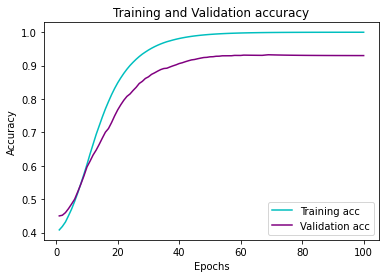

In [ ]:
smooth_acc_hist = smooth_curve(acc)
smooth_val_acc_hist = smooth_curve(val_acc)
plt.plot(range(1, len(smooth_acc_hist) + 1), smooth_acc_hist, 'c-', label='Training acc')
plt.plot(range(1, len(smooth_val_acc_hist) + 1), smooth_val_acc_hist, 'purple', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()